# 02 - ML Experimentation with Custom Model

The purpose of this notebook is to use [custom training](https://cloud.google.com/ai-platform-unified/docs/training/custom-training) to train a keras classifier to predict whether a given trip will result in a tip > 20%. The notebook covers the following tasks:
1. Preprocess the data locally using Apache Beam.
2. Train and test custom model locally using a Keras implementation.
3. Submit a Dataflow job to preprocess the data at scale.
4. Submit a custom training job to Vertex AI using a [pre-built container](https://cloud.google.com/ai-platform-unified/docs/training/pre-built-containers).
5. Upload the trained model to Vertex AI.
6. Track experiment parameters from [Vertex AI Metadata](https://cloud.google.com/vertex-ai/docs/ml-metadata/introduction).
7. Submit a [hyperparameter tuning job](https://cloud.google.com/vertex-ai/docs/training/hyperparameter-tuning-overview) to Vertex AI.

We use [Vertex TensorBoard](https://cloud.google.com/vertex-ai/docs/experiments/tensorboard-overview) 
and [Vertex ML Metadata](https://cloud.google.com/vertex-ai/docs/ml-metadata/introduction) to  track, visualize, and compare ML experiments.

## Setup

### Import libraries

In [2]:
import os
import logging
from datetime import datetime
import numpy as np

import tensorflow as tf
import tensorflow_transform as tft
import tensorflow.keras as keras

from google.cloud import aiplatform as vertex_ai
from google.cloud.aiplatform import hyperparameter_tuning as hp_tuning

from src.common import features, datasource_utils
from src.model_training import data, model, defaults, trainer, exporter
from src.preprocessing import etl

logging.getLogger().setLevel(logging.INFO)
tf.get_logger().setLevel('INFO')

print(f"TensorFlow: {tf.__version__}")
print(f"TensorFlow Transform: {tft.__version__}")

2022-07-22 01:50:41.362365: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-22 01:50:41.362407: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


TensorFlow: 2.5.3
TensorFlow Transform: 1.2.0


### Setup Google Cloud project

In [5]:
PROJECT = 'mloperations-357021' # Change to your project id.
REGION = 'us-central1' # Change to your region.
BUCKET = 'vertex-mlops-23bucket' # Change to your bucket name.
SERVICE_ACCOUNT = "Vertex Training service account"

if PROJECT == "" or PROJECT is None or PROJECT == "mloperations-357021":
    # Get your GCP project id from gcloud
    shell_output = !gcloud config list --format 'value(core.project)' 2>/dev/null
    PROJECT = shell_output[0]
    
if SERVICE_ACCOUNT == "" or SERVICE_ACCOUNT is None or SERVICE_ACCOUNT == "[your-service-account]":
    # Get your GCP project id from gcloud
    shell_output = !gcloud config list --format 'value(core.account)' 2>/dev/null
    SERVICE_ACCOUNT = shell_output[0]
    
if BUCKET == "" or BUCKET is None or BUCKET == "vertex-mlops-23bucket":
    # Get your bucket name to GCP projet id
    BUCKET = PROJECT
    # Try to create the bucket if it doesn'exists
    ! gsutil mb -l $REGION gs://$BUCKET
    print("")
    
PARENT = f"projects/{PROJECT}/locations/{REGION}"
    
print("Project ID:", PROJECT)
print("Region:", REGION)
print("Bucket name:", BUCKET)
print("Service Account:", SERVICE_ACCOUNT)
print("Vertex API Parent URI:", PARENT)

Creating gs://mloperations-357021/...

Project ID: mloperations-357021
Region: us-central1
Bucket name: mloperations-357021
Service Account: Vertex Training service account
Vertex API Parent URI: projects/mloperations-357021/locations/us-central1


### Set configurations

In [6]:
VERSION = 'v01'
DATASET_DISPLAY_NAME = 'citytaxitips'
MODEL_DISPLAY_NAME = f'{DATASET_DISPLAY_NAME}-classifier-{VERSION}'

WORKSPACE = f'gs://{BUCKET}/{DATASET_DISPLAY_NAME}'
EXPERIMENT_ARTIFACTS_DIR = os.path.join(WORKSPACE, 'experiments')
RAW_SCHEMA_LOCATION = 'src/raw_schema/schema.pbtxt'

TENSORBOARD_DISPLAY_NAME = f'tb-{DATASET_DISPLAY_NAME}'
EXPERIMENT_NAME = f'{MODEL_DISPLAY_NAME}'

## Create Vertex TensorBoard instance 

In [7]:
tensorboard_resource = vertex_ai.Tensorboard.create(display_name=TENSORBOARD_DISPLAY_NAME)
tensorboard_resource_name = tensorboard_resource.gca_resource.name
print("TensorBoard resource name:", tensorboard_resource_name)

Creating Tensorboard
Create Tensorboard backing LRO: projects/773483864631/locations/us-central1/tensorboards/7395667052142264320/operations/442187911283081216
Tensorboard created. Resource name: projects/773483864631/locations/us-central1/tensorboards/7395667052142264320
To use this Tensorboard in another session:
tb = aiplatform.Tensorboard('projects/773483864631/locations/us-central1/tensorboards/7395667052142264320')
TensorBoard resource name: projects/773483864631/locations/us-central1/tensorboards/7395667052142264320


## Initialize workspace

In [8]:
REMOVE_EXPERIMENT_ARTIFACTS = False

if tf.io.gfile.exists(EXPERIMENT_ARTIFACTS_DIR) and REMOVE_EXPERIMENT_ARTIFACTS:
    print("Removing previous experiment artifacts...")
    tf.io.gfile.rmtree(EXPERIMENT_ARTIFACTS_DIR)

if not tf.io.gfile.exists(EXPERIMENT_ARTIFACTS_DIR):
    print("Creating new experiment artifacts directory...")
    tf.io.gfile.mkdir(EXPERIMENT_ARTIFACTS_DIR)

print("Workspace is ready.")
print("Experiment directory:", EXPERIMENT_ARTIFACTS_DIR)

Creating new experiment artifacts directory...
Workspace is ready.
Experiment directory: gs://mloperations-357021/citytaxitips/experiments


## Initialize Vertex AI experiment

In [9]:
vertex_ai.init(
    project=PROJECT,
    location=REGION,
    staging_bucket=BUCKET,
    experiment=EXPERIMENT_NAME
)

run_id = f"run-local-{datetime.now().strftime('%Y%m%d%H%M%S')}"
vertex_ai.start_run(run_id)

EXPERIMENT_RUN_DIR = os.path.join(EXPERIMENT_ARTIFACTS_DIR, EXPERIMENT_NAME, run_id)
print("Experiment run directory:", EXPERIMENT_RUN_DIR)

Associating projects/773483864631/locations/us-central1/metadataStores/default/contexts/citytaxitips-classifier-v01-run-local-20220722015303 to Experiment: citytaxitips-classifier-v01
Experiment run directory: gs://mloperations-357021/citytaxitips/experiments/citytaxitips-classifier-v01/run-local-20220722015303


## 1. Preprocess the data using Apache Beam

The Apache Beam pipeline of data preprocessing is implemented in the [preprocessing](src/preprocessing) directory.

In [10]:
EXPORTED_DATA_PREFIX = os.path.join(EXPERIMENT_RUN_DIR, 'exported_data')
TRANSFORMED_DATA_PREFIX = os.path.join(EXPERIMENT_RUN_DIR, 'transformed_data')
TRANSFORM_ARTIFACTS_DIR = os.path.join(EXPERIMENT_RUN_DIR, 'transform_artifacts')

### Get Source Query from Managed Dataset

In [11]:
ML_USE = 'UNASSIGNED'
LIMIT = 5120

raw_data_query = datasource_utils.get_training_source_query(
    project=PROJECT, 
    region=REGION, 
    dataset_display_name=DATASET_DISPLAY_NAME, 
    ml_use=ML_USE, 
    limit=LIMIT
)

print(raw_data_query)


    SELECT 
        IF(trip_month IS NULL, -1, trip_month) trip_month,
        IF(trip_day IS NULL, -1, trip_day) trip_day,
        IF(trip_day_of_week IS NULL, -1, trip_day_of_week) trip_day_of_week,
        IF(trip_hour IS NULL, -1, trip_hour) trip_hour,
        IF(trip_seconds IS NULL, -1, trip_seconds) trip_seconds,
        IF(trip_miles IS NULL, -1, trip_miles) trip_miles,
        IF(payment_type IS NULL, 'NA', payment_type) payment_type,
        IF(pickup_grid IS NULL, 'NA', pickup_grid) pickup_grid,
        IF(dropoff_grid IS NULL, 'NA', dropoff_grid) dropoff_grid,
        IF(euclidean IS NULL, -1, euclidean) euclidean,
        IF(loc_cross IS NULL, 'NA', loc_cross) loc_cross,
        tip_bin
    FROM BQDataset.tbl_taxitrip 
    WHERE ML_use = 'UNASSIGNED'
    LIMIT 5120


### Test Data Preprocessing Locally

In [12]:
args = {
    'runner': 'DirectRunner',
    'raw_data_query': raw_data_query,
    'write_raw_data': True,
    'exported_data_prefix': EXPORTED_DATA_PREFIX,
    'transformed_data_prefix': TRANSFORMED_DATA_PREFIX,
    'transform_artifact_dir': TRANSFORM_ARTIFACTS_DIR,
    'temporary_dir': os.path.join(WORKSPACE, 'tmp'),
    'gcs_location': f'gs://{BUCKET}/bq_tmp',
    'project': PROJECT
}

In [13]:
vertex_ai.log_params(args)

In [14]:
print("Data preprocessing started...")
etl.run_transform_pipeline(args)
print("Data preprocessing completed.")

Data preprocessing started...


/home/jupyter/.local/lib/python3.7/site-packages/apache_beam/io/gcp/bigquery.py:2527: BeamDeprecationWarning: options is deprecated since First stable release. References to <pipeline>.options will not be supported
  temp_location = pcoll.pipeline.options.view_as(
INFO:absl:Feature dropoff_grid has a shape dim {
  size: 1
}
. Setting to DenseTensor.
INFO:absl:Feature euclidean has a shape dim {
  size: 1
}
. Setting to DenseTensor.
INFO:absl:Feature loc_cross has a shape dim {
  size: 1
}
. Setting to DenseTensor.
INFO:absl:Feature payment_type has a shape dim {
  size: 1
}
. Setting to DenseTensor.
INFO:absl:Feature pickup_grid has a shape dim {
  size: 1
}
. Setting to DenseTensor.
INFO:absl:Feature tip_bin has a shape dim {
  size: 1
}
. Setting to DenseTensor.
INFO:absl:Feature trip_day has a shape dim {
  size: 1
}
. Setting to DenseTensor.
INFO:absl:Feature trip_day_of_week has a shape dim {
  size: 1
}
. Setting to DenseTensor.
INFO:absl:Feature trip_hour has a shape dim {
  siz

Instructions for updating:
Use ref() instead.


2022-07-22 01:53:47.994643: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-22 01:53:47.994691: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-22 01:53:47.994717: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (vertex-mlops-notebook): /proc/driver/nvidia/version does not exist
2022-07-22 01:53:47.995127: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
Instructions for updating:
Use ref() instead.


2022-07-22 01:54:01.520770: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-07-22 01:54:01.521548: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2299995000 Hz
INFO:absl:Feature dropoff_grid has a shape dim {
  size: 1
}
. Setting to DenseTensor.
INFO:absl:Feature euclidean has a shape dim {
  size: 1
}
. Setting to DenseTensor.
INFO:absl:Feature loc_cross has a shape dim {
  size: 1
}
. Setting to DenseTensor.
INFO:absl:Feature payment_type has a shape dim {
  size: 1
}
. Setting to DenseTensor.
INFO:absl:Feature pickup_grid has a shape dim {
  size: 1
}
. Setting to DenseTensor.
INFO:absl:Feature tip_bin has a shape dim {
  size: 1
}
. Setting to DenseTensor.
INFO:absl:Feature trip_day has a shape dim {
  size: 1
}
. Setting to DenseTensor.
INFO:absl:Feature trip_day_of_week has a shape dim {
  size: 1
}
. Setting to DenseTensor.
INFO:absl:Feature trip_hour has a shape dim 

INFO:absl:Feature dropoff_grid has a shape dim {
  size: 1
}
. Setting to DenseTensor.
INFO:absl:Feature euclidean has a shape dim {
  size: 1
}
. Setting to DenseTensor.
INFO:absl:Feature loc_cross has a shape dim {
  size: 1
}
. Setting to DenseTensor.
INFO:absl:Feature payment_type has a shape dim {
  size: 1
}
. Setting to DenseTensor.
INFO:absl:Feature pickup_grid has a shape dim {
  size: 1
}
. Setting to DenseTensor.
INFO:absl:Feature tip_bin has a shape dim {
  size: 1
}
. Setting to DenseTensor.
INFO:absl:Feature trip_day has a shape dim {
  size: 1
}
. Setting to DenseTensor.
INFO:absl:Feature trip_day_of_week has a shape dim {
  size: 1
}
. Setting to DenseTensor.
INFO:absl:Feature trip_hour has a shape dim {
  size: 1
}
. Setting to DenseTensor.
INFO:absl:Feature trip_miles has a shape dim {
  size: 1
}
. Setting to DenseTensor.
INFO:absl:Feature trip_month has a shape dim {
  size: 1
}
. Setting to DenseTensor.
INFO:absl:Feature trip_seconds has a shape dim {
  size: 1
}
.

INFO:tensorflow:Assets written to: gs://mloperations-357021/citytaxitips/tmp/tftransform_tmp/8130d874ee3640fb95fdb4f90efe6866/assets


INFO:tensorflow:Assets written to: gs://mloperations-357021/citytaxitips/tmp/tftransform_tmp/8130d874ee3640fb95fdb4f90efe6866/assets
INFO:apache_beam.internal.gcp.auth:Setting socket default timeout to 60 seconds.
INFO:apache_beam.internal.gcp.auth:socket default timeout is 60.0 seconds.
INFO:apache_beam.io.gcp.bigquery_tools:Started BigQuery job: <JobReference
 location: 'US'
 projectId: 'mloperations-357021'>
 bq show -j --format=prettyjson --project_id=mloperations-357021 None
INFO:apache_beam.io.gcp.bigquery_tools:Using location 'US' from table <TableReference
 datasetId: 'BQDataset'
 projectId: 'mloperations-357021'
 tableId: 'tbl_taxitrip'> referenced by query 
    SELECT 
        IF(trip_month IS NULL, -1, trip_month) trip_month,
        IF(trip_day IS NULL, -1, trip_day) trip_day,
        IF(trip_day_of_week IS NULL, -1, trip_day_of_week) trip_day_of_week,
        IF(trip_hour IS NULL, -1, trip_hour) trip_hour,
        IF(trip_seconds IS NULL, -1, trip_seconds) trip_seconds,
  

INFO:tensorflow:Assets written to: gs://mloperations-357021/citytaxitips/tmp/tftransform_tmp/bc812464b4fa4b5d8ab01185bf8c0737/assets


INFO:tensorflow:Assets written to: gs://mloperations-357021/citytaxitips/tmp/tftransform_tmp/bc812464b4fa4b5d8ab01185bf8c0737/assets
INFO:apache_beam.io.gcp.gcsio:Starting the file information of the input
INFO:apache_beam.io.gcp.gcsio:Finished listing 0 files in 0.03754234313964844 seconds.
INFO:apache_beam.io.gcp.gcsio:Starting the file information of the input
INFO:apache_beam.io.gcp.gcsio:Finished listing 0 files in 0.031672000885009766 seconds.
INFO:apache_beam.io.gcp.gcsio:Starting the file information of the input
INFO:apache_beam.io.gcp.gcsio:Finished listing 1 files in 0.03328275680541992 seconds.
INFO:apache_beam.io.gcp.gcsio:Starting the file information of the input
INFO:apache_beam.io.gcp.gcsio:Finished listing 0 files in 0.043036460876464844 seconds.
INFO:apache_beam.io.filebasedsink:Starting finalize_write threads with num_shards: 1 (skipped: 0), batches: 1, num_threads: 1
INFO:apache_beam.io.filebasedsink:Renamed 1 shards in 0.20 seconds.
INFO:apache_beam.io.gcp.gcsio:S

Data preprocessing completed.


In [15]:
!gsutil ls {EXPERIMENT_RUN_DIR}

gs://mloperations-357021/citytaxitips/experiments/citytaxitips-classifier-v01/run-local-20220722015303/exported_data/
gs://mloperations-357021/citytaxitips/experiments/citytaxitips-classifier-v01/run-local-20220722015303/transform_artifacts/
gs://mloperations-357021/citytaxitips/experiments/citytaxitips-classifier-v01/run-local-20220722015303/transformed_data/


## 2. Train a custom model locally using a Keras

The `Keras` implementation of the custom model is in the [model_training](src/model_training) directory.

In [16]:
LOG_DIR = os.path.join(EXPERIMENT_RUN_DIR, 'logs')
EXPORT_DIR = os.path.join(EXPERIMENT_RUN_DIR, 'model')

### Read transformed data

In [17]:
tft_output = tft.TFTransformOutput(TRANSFORM_ARTIFACTS_DIR)
transform_feature_spec = tft_output.transformed_feature_spec()
transform_feature_spec

{'dropoff_grid_xf': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'euclidean_xf': FixedLenFeature(shape=[], dtype=tf.float32, default_value=None),
 'loc_cross_xf': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'payment_type_xf': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'pickup_grid_xf': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'tip_bin': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'trip_day_of_week_xf': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'trip_day_xf': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'trip_hour_xf': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'trip_miles_xf': FixedLenFeature(shape=[], dtype=tf.float32, default_value=None),
 'trip_month_xf': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'trip_seconds_xf': FixedLenFeature(shape=[], dtype=tf.float32, default_value=None)}

In [18]:
train_data_file_pattern = os.path.join(TRANSFORMED_DATA_PREFIX,'train/data-*.gz')
eval_data_file_pattern = os.path.join(TRANSFORMED_DATA_PREFIX,'eval/data-*.gz')

for input_features, target in data.get_dataset(
    train_data_file_pattern, transform_feature_spec, batch_size=3).take(1):
    for key in input_features:
        print(f"{key} {input_features[key].dtype}: {input_features[key].numpy().tolist()}")
    print(f"target: {target.numpy().tolist()}")

dropoff_grid_xf <dtype: 'int64'>: [0, 0, 0]
euclidean_xf <dtype: 'float32'>: [2.9366061687469482, 0.4624788165092468, -0.822114109992981]
loc_cross_xf <dtype: 'int64'>: [0, 0, 0]
payment_type_xf <dtype: 'int64'>: [2, 1, 1]
pickup_grid_xf <dtype: 'int64'>: [0, 0, 0]
trip_day_of_week_xf <dtype: 'int64'>: [0, 2, 6]
trip_day_xf <dtype: 'int64'>: [20, 12, 28]
trip_hour_xf <dtype: 'int64'>: [13, 14, 9]
trip_miles_xf <dtype: 'float32'>: [2.316619396209717, -0.14270873367786407, -0.5402200222015381]
trip_month_xf <dtype: 'int64'>: [4, 0, 0]
trip_seconds_xf <dtype: 'float32'>: [0.44947507977485657, -0.11555085331201553, -0.2935503423213959]
target: [0, 0, 1]


### Create hyperparameters

In [19]:
hyperparams = {
    "hidden_units": [64, 32]
}

hyperparams = defaults.update_hyperparams(hyperparams)
hyperparams

{'hidden_units': [64, 32],
 'learning_rate': 0.0001,
 'batch_size': 512,
 'num_epochs': 10}

### Create and test model inputs and outputs

In [20]:
classifier = model.create_binary_classifier(tft_output, hyperparams)
classifier.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
trip_month_xf (InputLayer)      [(None,)]            0                                            
__________________________________________________________________________________________________
trip_day_xf (InputLayer)        [(None,)]            0                                            
__________________________________________________________________________________________________
trip_day_of_week_xf (InputLayer [(None,)]            0                                            
__________________________________________________________________________________________________
trip_hour_xf (InputLayer)       [(None,)]            0                                            
______________________________________________________________________________________________

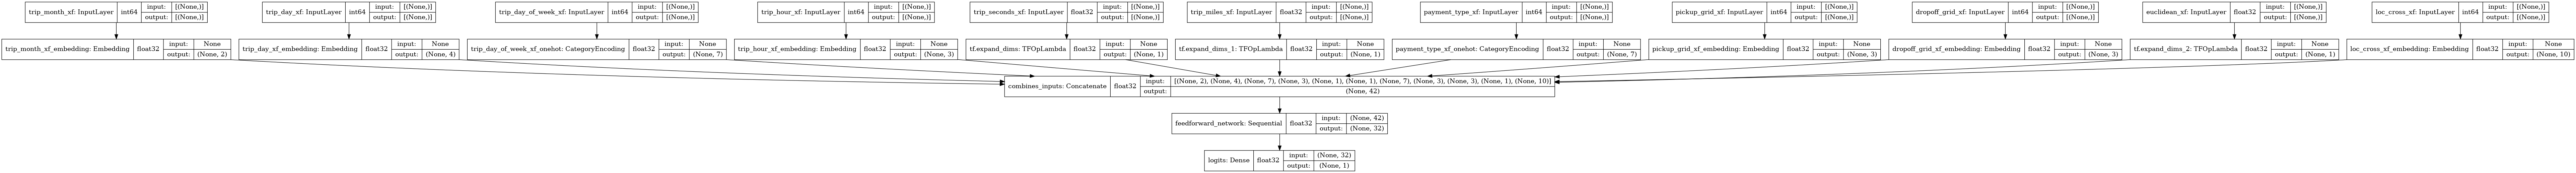

In [21]:
keras.utils.plot_model(
    classifier, 
    show_shapes=True, 
    show_dtype=True
)

In [22]:
classifier(input_features)

<tf.Tensor: shape=(3, 1), dtype=float32, numpy=
array([[-0.14979482],
       [ 0.02221474],
       [-0.13991237]], dtype=float32)>

### Train the model locally.

In [23]:
logging.getLogger().setLevel(logging.INFO)

hyperparams["learning_rate"] = 0.001
hyperparams["num_epochs"] = 5
hyperparams["batch_size"] = 512

vertex_ai.log_params(hyperparams)

TypeError: Value for key hidden_units is of type list but must be one of float, int, str

In [24]:
classifier = trainer.train(
    train_data_dir=train_data_file_pattern,
    eval_data_dir=eval_data_file_pattern,
    tft_output_dir=TRANSFORM_ARTIFACTS_DIR,
    hyperparams=hyperparams,
    log_dir=LOG_DIR,
)

INFO:root:Loading tft output from gs://mloperations-357021/citytaxitips/experiments/citytaxitips-classifier-v01/run-local-20220722015303/transform_artifacts
2022-07-22 01:58:42.222462: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-07-22 01:58:42.222521: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-07-22 01:58:42.222714: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.


INFO:root:Model training started...


Epoch 1/5
      2/Unknown - 1s 195ms/step - loss: 0.6182 - accuracy: 0.8799

2022-07-22 01:58:46.232424: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-07-22 01:58:46.232478: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-07-22 01:58:46.392464: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-07-22 01:58:46.395103: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-07-22 01:58:47.840093: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: gs://mloperations-357021/citytaxitips/experiments/citytaxitips-classifier-v01/run-local-20220722015303/logs/train/plugins/profile/2022_07_22_01_58_46
2022-07-22 01:58:47.985739: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to gs://mloperations-357021/citytaxitips/experiments/citytaxitips-classifier-v01/run-local-20220722015303/logs/train/plugins/profile/2022_07_22_01_58_46/vertex

      3/Unknown - 4s 2s/step - loss: 0.6079 - accuracy: 0.8861   

2022-07-22 01:58:49.064335: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: gs://mloperations-357021/citytaxitips/experiments/citytaxitips-classifier-v01/run-local-20220722015303/logs/train/plugins/profile/2022_07_22_01_58_46Dumped tool data for xplane.pb to gs://mloperations-357021/citytaxitips/experiments/citytaxitips-classifier-v01/run-local-20220722015303/logs/train/plugins/profile/2022_07_22_01_58_46/vertex-mlops-notebook.xplane.pb
Dumped tool data for overview_page.pb to gs://mloperations-357021/citytaxitips/experiments/citytaxitips-classifier-v01/run-local-20220722015303/logs/train/plugins/profile/2022_07_22_01_58_46/vertex-mlops-notebook.overview_page.pb
Dumped tool data for input_pipeline.pb to gs://mloperations-357021/citytaxitips/experiments/citytaxitips-classifier-v01/run-local-20220722015303/logs/train/plugins/profile/2022_07_22_01_58_46/vertex-mlops-notebook.input_pipeline.pb
Dumped tool data for tensorflow_stats.pb to gs://mloperations-3

8/8 [==============================] - 5s 604ms/step - loss: 0.5674 - accuracy: 0.8889 - val_loss: 0.5144 - val_accuracy: 0.8555
Epoch 2/5
8/8 [==============================] - 0s 38ms/step - loss: 0.4603 - accuracy: 0.8879 - val_loss: 0.4073 - val_accuracy: 0.8828
Epoch 3/5
8/8 [==============================] - 0s 47ms/step - loss: 0.3733 - accuracy: 0.8877 - val_loss: 0.3254 - val_accuracy: 0.8770
Epoch 4/5
8/8 [==============================] - 0s 43ms/step - loss: 0.3022 - accuracy: 0.8884 - val_loss: 0.3035 - val_accuracy: 0.8633
Epoch 5/5
8/8 [==============================] - 0s 36ms/step - loss: 0.2527 - accuracy: 0.8879 - val_loss: 0.2512 - val_accuracy: 0.8711


INFO:root:Model training completed.


In [25]:
val_loss, val_accuracy = trainer.evaluate(
    model=classifier,
    data_dir=eval_data_file_pattern,
    raw_schema_location=RAW_SCHEMA_LOCATION,
    tft_output_dir=TRANSFORM_ARTIFACTS_DIR,
    hyperparams=hyperparams,
)

INFO:root:Loading raw schema from src/raw_schema/schema.pbtxt
INFO:root:Loading tft output from gs://mloperations-357021/citytaxitips/experiments/citytaxitips-classifier-v01/run-local-20220722015303/transform_artifacts
INFO:root:Model evaluation started...


1/1 [==============================] - 0s 119ms/step - loss: 0.2461 - accuracy: 0.8770


INFO:root:Model evaluation completed.


In [26]:
vertex_ai.log_metrics(
    {"val_loss": val_loss, "val_accuracy": val_accuracy})

In [27]:
!tb-gcp-uploader --tensorboard_resource_name={tensorboard_resource_name} \
  --logdir={LOG_DIR} \
  --experiment_name={EXPERIMENT_NAME} --one_shot=True

2022-07-22 01:59:22.193768: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-22 01:59:22.193818: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
View your Tensorboard at https://us-central1.tensorboard.googleusercontent.com/experiment/projects+773483864631+locations+us-central1+tensorboards+7395667052142264320+experiments+citytaxitips-classifier-v01
[2022-07-22T01:59:25] Started scanning logdir.
[2022-07-22T01:59:25] Total uploaded: 30 scalars, 0 tensors, 1 binary objects (128.3 kB)


### Export the trained model

In [28]:
saved_model_dir = os.path.join(EXPORT_DIR)

exporter.export_serving_model(
    classifier=classifier,
    serving_model_dir=saved_model_dir,
    raw_schema_location=RAW_SCHEMA_LOCATION,
    tft_output_dir=TRANSFORM_ARTIFACTS_DIR,
)

INFO:root:Model export started...


INFO:tensorflow:Assets written to: gs://mloperations-357021/citytaxitips/experiments/citytaxitips-classifier-v01/run-local-20220722015303/model/assets


INFO:tensorflow:Assets written to: gs://mloperations-357021/citytaxitips/experiments/citytaxitips-classifier-v01/run-local-20220722015303/model/assets
INFO:root:Model export completed.


### Inspect model serving signatures

In [29]:
!saved_model_cli show --dir={saved_model_dir} --tag_set=serve --signature_def=serving_tf_example

/bin/bash: saved_model_cli: command not found


In [30]:
!saved_model_cli show --dir={saved_model_dir} --tag_set=serve --signature_def=serving_default

/bin/bash: saved_model_cli: command not found


### Test the exported SavedModel

In [31]:
serving_model = tf.saved_model.load(saved_model_dir)
print("Saved model is loaded.")

Saved model is loaded.


In [32]:
# Test the serving_tf_example with TF Examples

file_names = tf.data.TFRecordDataset.list_files(EXPORTED_DATA_PREFIX + '/data-*.tfrecord')
for batch in tf.data.TFRecordDataset(file_names).batch(3).take(1):
    predictions = serving_model.signatures['serving_tf_example'](batch)
    for key in predictions:
        print(f"{key}: {predictions[key]}")

probabilities: [[0.0810014 ]
 [0.08312574]
 [0.06697237]]


In [33]:
# Test the serving_default with feature dictionary

import tensorflow_data_validation as tfdv
from tensorflow_transform.tf_metadata import schema_utils

raw_schema = tfdv.load_schema_text(RAW_SCHEMA_LOCATION)
raw_feature_spec = schema_utils.schema_as_feature_spec(raw_schema).feature_spec

In [34]:
instance = {
    "dropoff_grid": "POINT(-87.6 41.9)",
    "euclidean": 2064.2696,
    "loc_cross": "",
    "payment_type": "Credit Card",
    "pickup_grid": "POINT(-87.6 41.9)",
    "trip_miles": 1.37,
    "trip_day": 12,
    "trip_hour": 6,
    "trip_month": 2,
    "trip_day_of_week": 4,
    "trip_seconds": 555,
}

for feature_name in instance:
    dtype = raw_feature_spec[feature_name].dtype
    instance[feature_name] = tf.constant([[instance[feature_name]]], dtype)

In [35]:
predictions = serving_model.signatures['serving_default'](**instance)
for key in predictions:
    print(f"{key}: {predictions[key].numpy()}")

classes: [[b'tip<20%' b'tip>=20%']]
scores: [[0.44841522 0.5515848 ]]


## Start a new Vertex AI experiment run

In [36]:
vertex_ai.init(
    project=PROJECT,
    staging_bucket=BUCKET,
    experiment=EXPERIMENT_NAME)

run_id = f"run-gcp-{datetime.now().strftime('%Y%m%d%H%M%S')}"
vertex_ai.start_run(run_id)

EXPERIMENT_RUN_DIR = os.path.join(EXPERIMENT_ARTIFACTS_DIR, EXPERIMENT_NAME, run_id)
print("Experiment run directory:", EXPERIMENT_RUN_DIR)

Associating projects/773483864631/locations/us-central1/metadataStores/default/contexts/citytaxitips-classifier-v01-run-gcp-20220722020256 to Experiment: citytaxitips-classifier-v01


INFO:google.cloud.aiplatform.metadata.experiment_resources:Associating projects/773483864631/locations/us-central1/metadataStores/default/contexts/citytaxitips-classifier-v01-run-gcp-20220722020256 to Experiment: citytaxitips-classifier-v01


Experiment run directory: gs://mloperations-357021/citytaxitips/experiments/citytaxitips-classifier-v01/run-gcp-20220722020256


## 3. Submit a Data Processing Job to Dataflow

In [46]:
EXPORTED_DATA_PREFIX = os.path.join(EXPERIMENT_RUN_DIR, 'exported_data')
TRANSFORMED_DATA_PREFIX = os.path.join(EXPERIMENT_RUN_DIR, 'transformed_data')
TRANSFORM_ARTIFACTS_DIR = os.path.join(EXPERIMENT_RUN_DIR, 'transform_artifacts')

In [47]:
ML_USE = 'UNASSIGNED'
LIMIT = 1000000
raw_data_query = datasource_utils.get_training_source_query(
    project=PROJECT, 
    region=REGION, 
    dataset_display_name=DATASET_DISPLAY_NAME, 
    ml_use=ML_USE, 
    limit=LIMIT
)

etl_job_name = f"etl1-{MODEL_DISPLAY_NAME}-{run_id}"

args = {
    'job_name': etl_job_name,
    'runner': 'DataflowRunner',
    'raw_data_query': raw_data_query,
    'exported_data_prefix': EXPORTED_DATA_PREFIX,
    'transformed_data_prefix': TRANSFORMED_DATA_PREFIX,
    'transform_artifact_dir': TRANSFORM_ARTIFACTS_DIR,
    'write_raw_data': False,
    'temporary_dir': os.path.join(WORKSPACE, 'tmp'),
    'gcs_location': os.path.join(WORKSPACE, 'bq_tmp'),
    'project': PROJECT,
    'region': REGION,
    'setup_file': './setup.py'
}

In [48]:
vertex_ai.log_params(args)

In [ ]:
logging.getLogger().setLevel(logging.ERROR)

print("Data preprocessing started...")
etl.run_transform_pipeline(args)
print("Data preprocessing completed.")

Data preprocessing started...


In [ ]:
!gsutil ls {EXPERIMENT_RUN_DIR}

In [43]:
#!gcloud beta dataflow jobs list --status=active

`--region` not set; getting jobs from all available regions. Some jobs may be missing in the event of an outage. https://cloud.google.com/dataflow/docs/concepts/regional-endpoints
JOB_ID                                    NAME                                                    TYPE   CREATION_TIME        STATE    REGION
2022-07-21_19_04_16-12091807891579605366  etl-citytaxitips-classifier-v01-run-gcp-20220722020256  Batch  2022-07-22 02:04:18  Running  us-central1


In [45]:
#etl-citytaxitips-classifier-v01-run-gcp-20220722020256
!gcloud beta dataflow jobs delete 2022-07-21_19_04_16-12091807891579605366

ERROR: (gcloud.beta.dataflow.jobs) Invalid choice: 'delete'.
Maybe you meant:
  gcloud beta dataflow jobs export-steps
  gcloud dataflow jobs cancel
  gcloud dataflow jobs describe
  gcloud dataflow jobs drain
  gcloud dataflow jobs list
  gcloud dataflow jobs run
  gcloud dataflow jobs show
  gcloud beta batch jobs delete
  gcloud beta run jobs delete
  gcloud beta run jobs executions delete

To search the help text of gcloud commands, run:
  gcloud help -- SEARCH_TERMS


## 4. Submit a Custom Training Job to Vertex AI

In [ ]:
LOG_DIR = os.path.join(EXPERIMENT_RUN_DIR, 'logs')
EXPORT_DIR = os.path.join(EXPERIMENT_RUN_DIR, 'model')

### Test the training task locally

In [ ]:
!python -m src.model_training.task \
    --model-dir={EXPORT_DIR} \
    --log-dir={LOG_DIR} \
    --train-data-dir={TRANSFORMED_DATA_PREFIX}/train/* \
    --eval-data-dir={TRANSFORMED_DATA_PREFIX}/eval/*  \
    --tft-output-dir={TRANSFORM_ARTIFACTS_DIR} \
    --num-epochs=3 \
    --hidden-units=32,32 \
    --experiment-name={EXPERIMENT_NAME} \
    --run-name={run_id} \
    --project={PROJECT} \
    --region={REGION} \
    --staging-bucket={BUCKET}

### Prepare training package

In [ ]:
TRAINER_PACKAGE_DIR = os.path.join(WORKSPACE, 'trainer_packages')
TRAINER_PACKAGE_NAME = f'{MODEL_DISPLAY_NAME}_trainer'
print("Trainer package upload location:", TRAINER_PACKAGE_DIR)

In [ ]:
!rm -r src/__pycache__/
!rm -r src/.ipynb_checkpoints/
!rm -r src/raw_schema/.ipynb_checkpoints/
!rm -f {TRAINER_PACKAGE_NAME}.tar {TRAINER_PACKAGE_NAME}.tar.gz

!mkdir {TRAINER_PACKAGE_NAME}

!cp setup.py {TRAINER_PACKAGE_NAME}/
!cp -r src {TRAINER_PACKAGE_NAME}/
!tar cvf {TRAINER_PACKAGE_NAME}.tar {TRAINER_PACKAGE_NAME}
!gzip {TRAINER_PACKAGE_NAME}.tar
!gsutil cp {TRAINER_PACKAGE_NAME}.tar.gz {TRAINER_PACKAGE_DIR}/
!rm -r {TRAINER_PACKAGE_NAME}
!rm -r {TRAINER_PACKAGE_NAME}.tar.gz

### Prepare the training job

In [ ]:
TRAIN_RUNTIME = 'tf-cpu.2-5'
TRAIN_IMAGE = f"us-docker.pkg.dev/vertex-ai/training/{TRAIN_RUNTIME}:latest"
print("Training image:", TRAIN_IMAGE)

In [ ]:
num_epochs = 10
learning_rate = 0.001
hidden_units = "64,64"

trainer_args = [
    f'--train-data-dir={TRANSFORMED_DATA_PREFIX + "/train/*"}',
    f'--eval-data-dir={TRANSFORMED_DATA_PREFIX + "/eval/*"}',
    f'--tft-output-dir={TRANSFORM_ARTIFACTS_DIR}',
    f'--num-epochs={num_epochs}',
    f'--learning-rate={learning_rate}',
    f'--project={PROJECT}',
    f'--region={REGION}',
    f'--staging-bucket={BUCKET}',
    f'--experiment-name={EXPERIMENT_NAME}'
]

In [ ]:
package_uri = os.path.join(TRAINER_PACKAGE_DIR, f'{TRAINER_PACKAGE_NAME}.tar.gz')

worker_pool_specs = [
    {
        "replica_count": 1,
        "machine_spec": {
            "machine_type": 'n1-standard-4',
            "accelerator_count": 0
    },
        "python_package_spec": {
            "executor_image_uri": TRAIN_IMAGE,
            "package_uris": [package_uri],
            "python_module": "src.model_training.task",
            "args": trainer_args,
        }
    }
]

### Submit the training job

In [ ]:
print("Submitting a custom training job...")

training_job_display_name = f"{TRAINER_PACKAGE_NAME}_{run_id}"

training_job = vertex_ai.CustomJob(
    display_name=training_job_display_name,
    worker_pool_specs=worker_pool_specs,
    base_output_dir=EXPERIMENT_RUN_DIR,
)

training_job.run(
    service_account=SERVICE_ACCOUNT,
    tensorboard=tensorboard_resource_name,
    sync=True
)

## 5. Upload exported model to Vertex AI Models

In [ ]:
!gsutil ls {EXPORT_DIR}

### Generate the Explanation metadata

In [ ]:
explanation_config = features.generate_explanation_config()
explanation_config

### Upload model

In [ ]:
SERVING_RUNTIME='tf2-cpu.2-5'
SERVING_IMAGE = f"us-docker.pkg.dev/vertex-ai/prediction/{SERVING_RUNTIME}:latest"
print("Serving image:", SERVING_IMAGE)

In [ ]:
explanation_metadata = vertex_ai.explain.ExplanationMetadata(
    inputs=explanation_config["inputs"],
    outputs=explanation_config["outputs"],
)
explanation_parameters = vertex_ai.explain.ExplanationParameters(
    explanation_config["params"]
)

vertex_model = vertex_ai.Model.upload(
    display_name=MODEL_DISPLAY_NAME,
    artifact_uri=EXPORT_DIR,
    serving_container_image_uri=SERVING_IMAGE,
    parameters_schema_uri=None,
    instance_schema_uri=None,
    explanation_metadata=explanation_metadata,
    explanation_parameters=explanation_parameters,
    labels={
        'dataset_name': DATASET_DISPLAY_NAME,
        'experiment': run_id
    }
)

In [ ]:
vertex_model.gca_resource

## 6. Extract experiment run parameters

In [ ]:
experiment_df = vertex_ai.get_experiment_df()
experiment_df = experiment_df[experiment_df.experiment_name == EXPERIMENT_NAME]
experiment_df.T

In [ ]:
print("Vertex AI Experiments:")
print(
    f"https://console.cloud.google.com/vertex-ai/locations{REGION}/experiments/{EXPERIMENT_NAME}/metrics?project={PROJECT}"
)

## 7. Submit a Hyperparameter Tuning Job to Vertex AI

For more information about configuring a hyperparameter study, refer to [Vertex AI Hyperparameter job configuration](https://cloud.google.com/vertex-ai/docs/training/using-hyperparameter-tuning).

### Configure a hyperparameter job

In [ ]:
metric_spec = {
    'ACCURACY': 'maximize'
}

parameter_spec = {
    'learning-rate': hp_tuning.DoubleParameterSpec(min=0.0001, max=0.01, scale='log'),
    'hidden-units': hp_tuning.CategoricalParameterSpec(values=["32,32", "64,64", "128,128"])
}

In [ ]:
tuning_job_display_name = f"hpt_{TRAINER_PACKAGE_NAME}_{run_id}"

hp_tuning_job = vertex_ai.HyperparameterTuningJob(
    display_name=tuning_job_display_name,
    custom_job=training_job,
    metric_spec=metric_spec,
    parameter_spec=parameter_spec,
    max_trial_count=4,
    parallel_trial_count=2,
    search_algorithm=None # Bayesian optimization.
)

### Submit the hyperparameter tuning job

In [ ]:
print("Submitting a hyperparameter tunning job...")

hp_tuning_job.run(
    service_account=SERVICE_ACCOUNT,
    tensorboard=tensorboard_resource_name,
    restart_job_on_worker_restart=False,
    sync=True,
)

### Retrieve trial results

In [ ]:
hp_tuning_job.trials

In [ ]:
best_trial = sorted(
    hp_tuning_job.trials, 
    key=lambda trial: trial.final_measurement.metrics[0].value, 
    reverse=True
)[0]

print("Best trial ID:", best_trial.id)
print("Validation Accuracy:", best_trial.final_measurement.metrics[0].value)
print("Hyperparameter Values:")
for parameter in best_trial.parameters:
    print(f" - {parameter.parameter_id}:{parameter.value}")